In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import seaborn as sns
import scipy.stats
import cellbayesassay as cba
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
my_treatments = ['TI21', 'TI22', 'TI26']

concentrations = {
    ('TI21', 1): 100e-6,
    ('TI21', 2): 10e-6,
    ('TI21', 3): 1e-6,
    ('TI22', 1): 10e-6,
    ('TI22', 2): 3e-6,
    ('TI22', 3): 1e-6,
    ('TI26', 1): 10e-6,
    ('TI26', 2): 3e-6,
    ('TI26', 3): 1e-6,
}



def get_concentration(TI, conc, concentrations=concentrations):
    TI = TI.strip()
    if re.match('^TI.*', TI):
        val = concentrations[(TI, conc)]
    else:
        val = concentrations[TI]
    return(val)

fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum.xlsx'
datad = {}

def read_data(sheet_name, assays, mean_sem_col='Group', skiprows=0):
    data = pd.read_excel(fpath, sheet_name=sheet_name, skiprows=skiprows)
    data = data.loc[~ data[mean_sem_col].isin(['mean', 'SEM'])]
    data['TI'] = data.TI.apply(lambda s: re.sub('TI\\s+', 'TI', s)).str.strip()
    data = data.applymap(lambda x: 0 if x == '<LOD' else x)
    data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
    data_nonassays = data.loc[:, ~ data.columns.isin(assays)]
    data_assays = pd.concat([data[a].astype(np.float64).to_frame(a) for a in assays], axis=1)
    data = pd.concat([data_nonassays, data_assays], axis=1)
    return(data)

def add_concentrations(data, concentrations):
    data['concentration'] = data.apply(lambda r: get_concentration(r.loc['TI'], r.loc['conc'], concentrations=concentrations), axis=1)
    data['conc_log10'] = data.concentration.apply(np.log10)
    return(data)


In [3]:
concentrations_Ab_release = concentrations.copy()
concentrations_Ab_release.update({
    'VC': 1e-9,
})
sheet_name = 'Abeta release'
data = read_data(sheet_name=sheet_name, assays=['Aβ38', 'Aβ40', 'Aβ42'], mean_sem_col='Group', skiprows=1)
data['TI'] = data.TI.apply(lambda s: re.sub('^VC.*', 'VC', s))
data = add_concentrations(data, concentrations=concentrations_Ab_release)
datad[sheet_name] = data
data

,plate,Group,ID,TI,conc,Aβ38,Aβ40,Aβ42,concentration,conc_log10
0,1.0,A1,TI21 c1_1,TI21,1.0,3401.0,14276.0,1128.0,1.000000e-04,-4.0
1,1.0,A1,TI21 c1_2,TI21,1.0,3468.0,14353.0,1011.0,1.000000e-04,-4.0
2,1.0,A1,TI21 c1_3,TI21,1.0,3190.0,13622.0,970.0,1.000000e-04,-4.0
3,1.0,A1,TI21 c1_4,TI21,1.0,4390.0,19144.0,1262.0,1.000000e-04,-4.0
4,1.0,A1,TI21 c1_5,TI21,1.0,3782.0,15602.0,1163.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...,...
81,5.0,K,VC_4_2,VC,NaN,3016.0,15962.0,1406.0,1.000000e-09,-9.0
82,5.0,K,VC_4_3,VC,NaN,2296.0,13190.0,1304.0,1.000000e-09,-9.0
83,5.0,K,VC_4_4,VC,NaN,2517.0,12753.0,1269.0,1.000000e-09,-9.0
84,5.0,K,VC_4_5,VC,NaN,3121.0,16302.0,1644.0,1.000000e-09,-9.0


In [4]:
concentrations_LPS = concentrations.copy()
concentrations_LPS.update({
    'LPS': 1e-9,
    'VC+L': 1e-9,
})
sheet_name = 'LPS'
assays_LPS = ['IFN-γ', 'IL-10', 'IL-12p70', 'IL-1β', 'IL-2', 'IL-4', 'IL-5', 'IL-6', 'KC/GRO', 'TNF-α']
data = read_data(sheet_name=sheet_name, assays=assays_LPS, mean_sem_col='Group', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_LPS)
datad[sheet_name] = data
data

,Cohort,Group,IRN,TI,conc,IFN-γ,IL-10,IL-12p70,IL-1β,IL-2,IL-4,IL-5,IL-6,KC/GRO,TNF-α,concentration,conc_log10
0,2.0,I1,TI 21 C1_1,TI21,1.0,0.000,6.53,48.48,0.61,0.50,0.000,0.00,12938.0,9.36,1734.0,1.000000e-04,-4.0
1,2.0,I1,TI 21 C1_2,TI21,1.0,0.197,8.05,61.95,1.71,1.39,0.000,0.13,13352.0,7.25,1601.0,1.000000e-04,-4.0
2,2.0,I1,TI 21 C1_3,TI21,1.0,0.023,6.97,143.32,0.84,0.46,0.026,0.65,13167.0,9.89,1333.0,1.000000e-04,-4.0
3,2.0,I1,TI 21 C1_4,TI21,1.0,0.038,6.25,4.21,0.72,0.00,0.000,0.00,8040.0,6.21,1670.0,1.000000e-04,-4.0
4,2.0,I1,TI 21 C1_5,TI21,1.0,0.004,5.60,23.70,0.90,0.00,0.000,0.00,6801.0,6.78,1272.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,5.0,LPS 5,VC+LPS_5_2,LPS,NaN,0.019,6.87,44.88,1.52,0.00,0.081,0.17,19845.0,13.87,1989.0,1.000000e-09,-9.0
90,5.0,LPS 5,VC+LPS_5_3,LPS,NaN,0.000,8.26,18.15,1.42,1.59,0.000,0.00,21097.0,12.33,2243.0,1.000000e-09,-9.0
91,5.0,LPS 5,VC+LPS_5_4,LPS,NaN,0.000,7.52,56.22,1.44,0.00,0.000,1.84,21231.0,25.92,2156.0,1.000000e-09,-9.0
92,5.0,LPS 5,VC+LPS_5_5,LPS,NaN,0.012,8.55,82.39,2.39,0.64,0.197,2.00,26174.0,21.33,2811.0,1.000000e-09,-9.0


In [5]:
def get_treatment_data(compound='TI21', data=data, my_treatments=my_treatments):
    mt = my_treatments.copy()
    mt.remove(compound)
    data = data.loc[~ data.TI.isin(mt)]
    return(data)

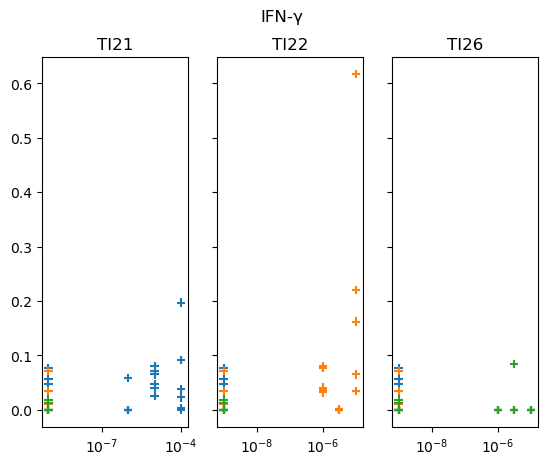

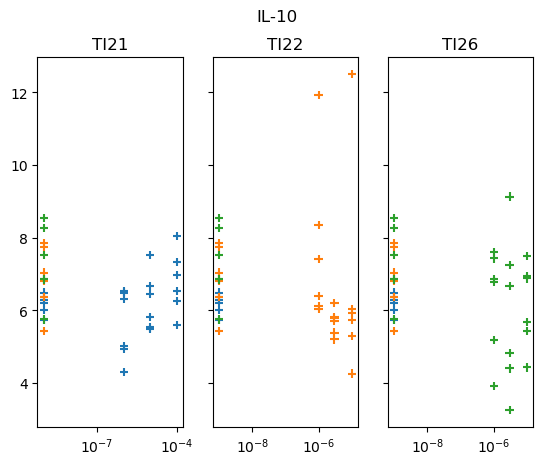

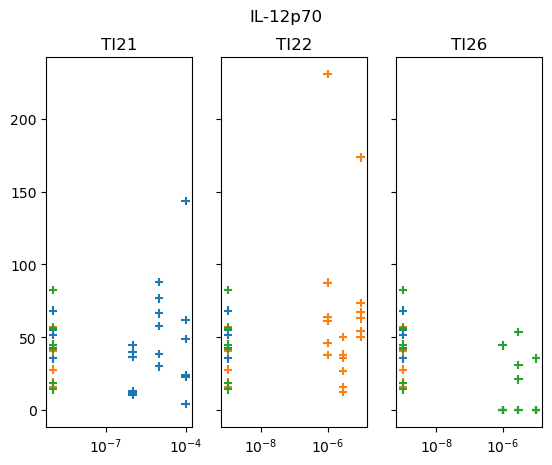

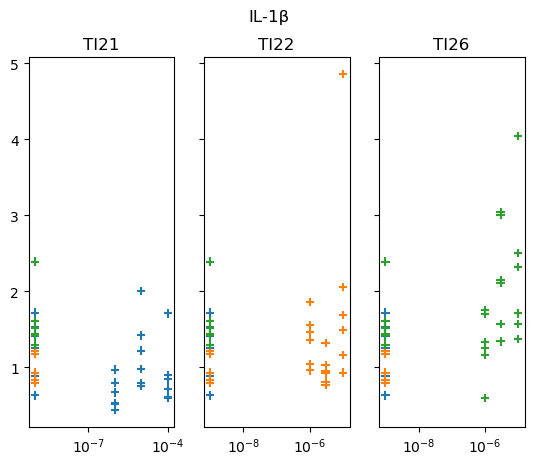

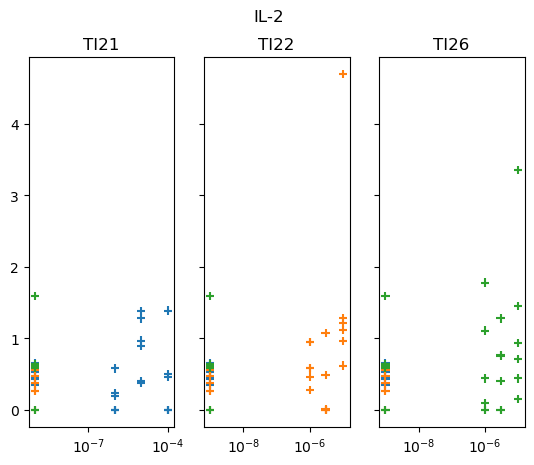

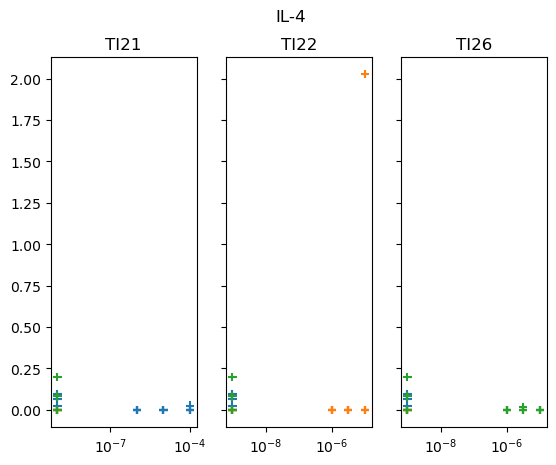

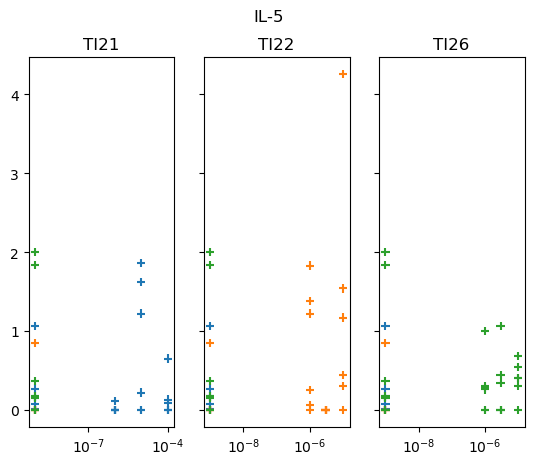

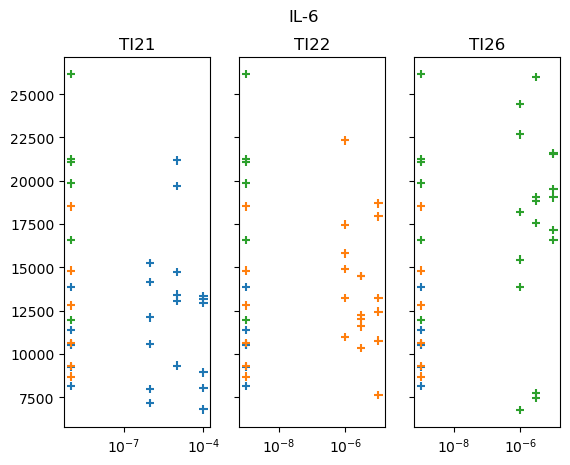

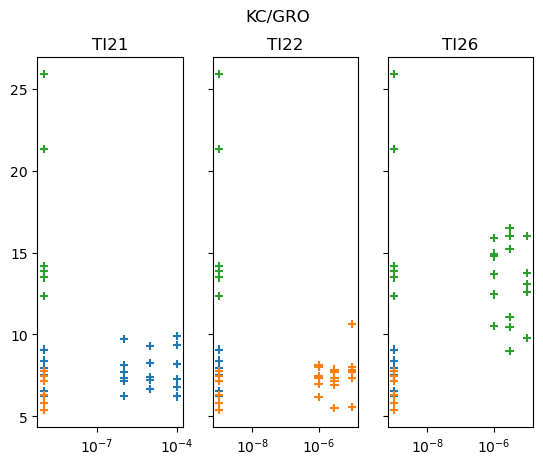

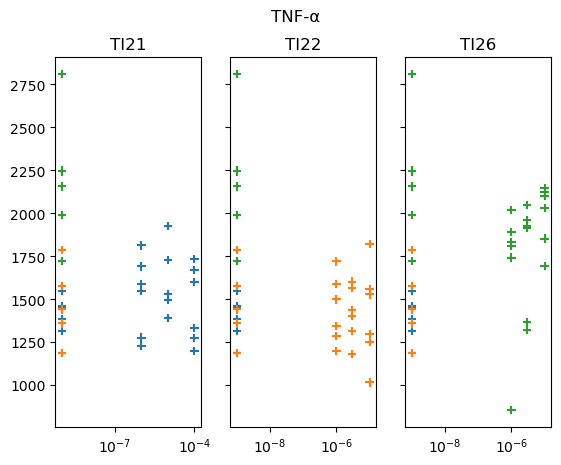

In [6]:
def data_plotter(assay, data, group_var):
    groups = data[group_var].unique()
    groupd = dict(zip(groups, ['C' + str(i) for i in range(len(groups))]))
    data['color'] = data[group_var].apply(lambda x: groupd[x])
    fig, ax = plt.subplots(1, len(my_treatments), sharey=True)
    for axi, compound in zip(ax, my_treatments):
        axi.scatter(x='concentration', y=assay, c='color', data=get_treatment_data(compound, data=data), marker='+')
        axi.set_xscale('log')
        axi.set_title(compound)
    fig.suptitle(assay)
    return((fig, ax))


for assay in assays_LPS:
    fig, ax = data_plotter(assay, datad['LPS'], 'Cohort')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

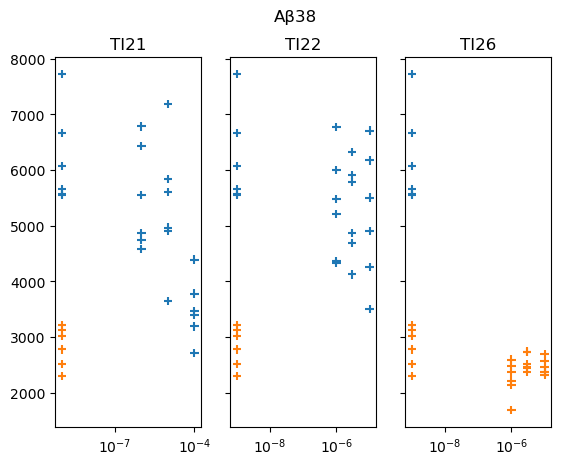

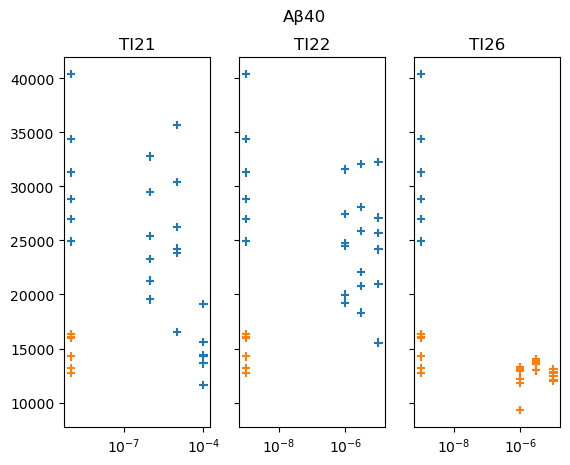

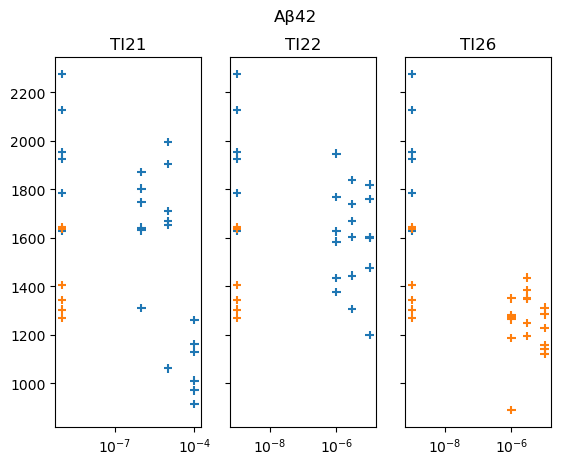

In [7]:
for assay in ['Aβ38', 'Aβ40', 'Aβ42']:
    fig, ax = data_plotter(assay, datad['Abeta release'], 'plate')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

In [8]:
%connect_info

{
  "shell_port": 54797,
  "iopub_port": 54798,
  "stdin_port": 54799,
  "control_port": 54801,
  "hb_port": 54800,
  "ip": "127.0.0.1",
  "key": "f440f37c-b81acd0e58fed9e1046c5f0d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-0ff66d66-1ea0-48fc-bbde-59ce6aeb8acc.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
